In [1]:
import sklearn
import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import io
import seaborn as sns

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix 

from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.utils import normalize, to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold


def display_scores(scores):
    print("\nScores:",scores)
    print("\nMean:",scores.mean())
    print("\nStandard Deviation:",scores.std())

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Daragh's Big Mad Joint Database.csv to Daragh's Big Mad Joint Database.csv


In [3]:
df = pd.read_csv(io.StringIO(uploaded["Daragh's Big Mad Joint Database.csv"].decode('utf-8')))

df['Date'] = pd.to_datetime(df['Date'])
#df.set_index('Date', inplace=True)

df

,Date,Bitcoin_price,Ethereum_price,Cardano_price,Ripple_price,S&P500,DJI,NASDAQ,Gold,Silver,Commodities,T_Bill,Oil,Twitter_volume,Google_trends
0,2013-01-10,123.65499,0.000000,0.000000,0.000000,1695.000000,15191.70020,3817.979980,124.589996,20.410000,31.879999,2.646,102.040001,0,2.0
1,2013-02-10,125.45500,0.000000,0.000000,0.000000,1693.869995,15133.13965,3815.020020,127.059998,20.920000,32.360001,2.626,104.099998,0,2.0
2,2013-03-10,108.58483,0.000000,0.000000,0.000000,1678.660034,14996.48047,3774.340088,127.180000,20.920000,32.270000,2.606,103.309998,0,2.0
3,2013-04-10,118.67466,0.000000,0.000000,0.000000,1690.500000,15072.58008,3807.750000,126.529999,20.930000,32.400002,2.652,103.839996,0,2.0
4,2013-05-10,121.33866,0.000000,0.000000,0.000000,1690.500000,15072.58008,3807.750000,126.529999,20.930000,32.400002,2.652,103.839996,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,2021-02-22,54181.91465,1782.149591,1.095003,0.575107,3876.500000,31521.68945,13533.049810,169.509995,26.270000,14.350000,1.370,61.490002,0,NaN
2662,2021-02-23,48172.87748,1546.622961,0.926067,0.461140,3881.370117,31537.34961,13465.200200,169.119995,25.709999,14.440000,1.362,61.669998,0,NaN
2663,2021-02-24,48745.43298,1589.266801,1.025853,0.460246,3925.429932,31961.85938,13597.969730,169.000000,25.940001,14.640000,1.389,63.220001,0,NaN
2664,2021-02-25,48291.41208,1524.180606,1.106722,0.453069,3829.340088,31402.00977,13119.429690,165.820007,25.400000,14.540000,1.518,63.529999,0,NaN


In [4]:
df1 = df[df.isna().any(axis=1)]
df1

,Date,Bitcoin_price,Ethereum_price,Cardano_price,Ripple_price,S&P500,DJI,NASDAQ,Gold,Silver,Commodities,T_Bill,Oil,Twitter_volume,Google_trends
2661,2021-02-22,54181.91465,1782.149591,1.095003,0.575107,3876.500000,31521.68945,13533.04981,169.509995,26.270000,14.35,1.370,61.490002,0,NaN
2662,2021-02-23,48172.87748,1546.622961,0.926067,0.461140,3881.370117,31537.34961,13465.20020,169.119995,25.709999,14.44,1.362,61.669998,0,NaN
2663,2021-02-24,48745.43298,1589.266801,1.025853,0.460246,3925.429932,31961.85938,13597.96973,169.000000,25.940001,14.64,1.389,63.220001,0,NaN
2664,2021-02-25,48291.41208,1524.180606,1.106722,0.453069,3829.340088,31402.00977,13119.42969,165.820007,25.400000,14.54,1.518,63.529999,0,NaN
2665,2021-02-26,45752.11492,1435.724418,1.204905,0.424884,3811.149902,30932.36914,13192.34961,161.809998,24.660000,14.24,1.460,61.500000,0,NaN


In [5]:
df = df.interpolate(method ='linear', axis=0, limit_direction ='forward', limit=5) 

In [6]:
df.size

39990

In [7]:
df.describe()

,Bitcoin_price,Ethereum_price,Cardano_price,Ripple_price,S&P500,DJI,NASDAQ,Gold,Silver,Commodities,T_Bill,Oil,Twitter_volume,Google_trends
count,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,5061.133894,190.119903,0.037265,0.113516,2486.778548,21703.820064,6624.110475,128.107018,16.728998,17.923901,2.098906,58.029321,6289.723556,10.413728
std,7059.006196,290.000817,0.096850,0.164524,523.299866,4505.593346,2269.967181,19.284935,2.776803,6.527499,0.649049,19.603626,14914.970316,13.819754
min,108.584830,0.000000,0.000000,0.000000,1655.449951,14776.530270,3677.780029,100.500000,11.210000,7.930000,0.499000,-37.630001,0.000000,2.000000
25%,451.403323,0.000000,0.000000,0.000000,2057.264893,17634.740230,4830.470215,116.585001,14.920000,14.390000,1.767000,45.919998,0.000000,2.000000
50%,2142.984995,92.866552,0.000000,0.000000,2399.290039,21005.710940,6140.419922,122.099998,16.020000,15.610000,2.239000,53.154998,0.000000,7.000000
75%,8151.499635,258.638484,0.046656,0.250569,2853.567566,25740.730468,7863.265137,128.470001,17.860001,18.515000,2.560000,63.497501,0.000000,12.000000
max,57128.642610,1958.739190,1.204905,0.684358,3934.830078,31961.859380,14095.469730,193.889999,27.000000,34.310001,3.234000,107.260002,132408.000000,100.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            2666 non-null   datetime64[ns]
 1   Bitcoin_price   2666 non-null   float64       
 2   Ethereum_price  2666 non-null   float64       
 3   Cardano_price   2666 non-null   float64       
 4   Ripple_price    2666 non-null   float64       
 5   S&P500          2666 non-null   float64       
 6   DJI             2666 non-null   float64       
 7   NASDAQ          2666 non-null   float64       
 8   Gold            2666 non-null   float64       
 9   Silver          2666 non-null   float64       
 10  Commodities     2666 non-null   float64       
 11  T_Bill          2666 non-null   float64       
 12  Oil             2666 non-null   float64       
 13  Twitter_volume  2666 non-null   int64         
 14  Google_trends   2666 non-null   float64       
dtypes: d

In [9]:
df.Google_trends.unique()

array([  2.,   3.,   4.,   5.,   7.,   6.,  10.,  12.,  19.,  13.,  11.,
         9.,  15.,  20.,  16.,  17.,  18.,  21.,  27.,  29.,  32.,  28.,
        64.,  91.,  83., 100.,  49.,  47.,  58.,  38.,  41.,  48.,  25.,
        14.,   8.,  22.,  24.,  71.,  66.,  42.,  40.,  36.,  60.,  59.,
        72.])

In [10]:
#sns.pairplot(df.dropna())

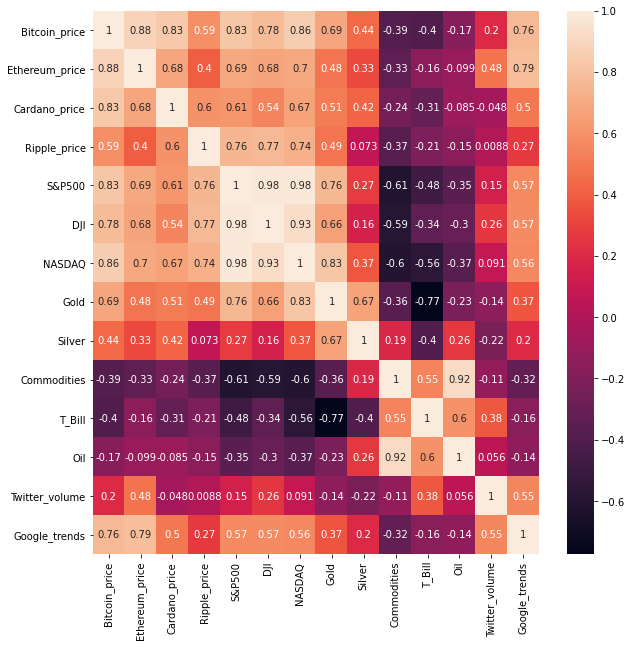

In [11]:
# numerical correlation
plt.figure(figsize=(10,10))

corr = df.corr()
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0)
plt.show()

*   **Size:** Dataset has 15 numerical variables, 14 'independent' and 1 dependent (Bitcoin price)
*   **Splitting:** Dataset is small with only 64124 observations suggesting more sophisticated method might be useful for training models, especially for ensembles where multiple models are used
*   **Linearity:** A pair plot of the numeric variables reveals that both positive and negative linear relationships exist between several of the independent variables and the dependent variable
 *  This suggests linear relationships may have some success at predicting future Bitcoin price
 *  A correlation matrix confirms this linearity

In [12]:
df['Bitcoin_price'].pct_change()

0            NaN
1       0.014557
2      -0.134472
3       0.092921
4       0.022448
          ...   
2661   -0.051581
2662   -0.110905
2663    0.011885
2664   -0.009314
2665   -0.052583
Name: Bitcoin_price, Length: 2666, dtype: float64

In [13]:
df['Bitcoin_price_change'] = df['Bitcoin_price'].diff()
df

,Date,Bitcoin_price,Ethereum_price,Cardano_price,Ripple_price,S&P500,DJI,NASDAQ,Gold,Silver,Commodities,T_Bill,Oil,Twitter_volume,Google_trends,Bitcoin_price_change
0,2013-01-10,123.65499,0.000000,0.000000,0.000000,1695.000000,15191.70020,3817.979980,124.589996,20.410000,31.879999,2.646,102.040001,0,2.0,NaN
1,2013-02-10,125.45500,0.000000,0.000000,0.000000,1693.869995,15133.13965,3815.020020,127.059998,20.920000,32.360001,2.626,104.099998,0,2.0,1.80001
2,2013-03-10,108.58483,0.000000,0.000000,0.000000,1678.660034,14996.48047,3774.340088,127.180000,20.920000,32.270000,2.606,103.309998,0,2.0,-16.87017
3,2013-04-10,118.67466,0.000000,0.000000,0.000000,1690.500000,15072.58008,3807.750000,126.529999,20.930000,32.400002,2.652,103.839996,0,2.0,10.08983
4,2013-05-10,121.33866,0.000000,0.000000,0.000000,1690.500000,15072.58008,3807.750000,126.529999,20.930000,32.400002,2.652,103.839996,0,2.0,2.66400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,2021-02-22,54181.91465,1782.149591,1.095003,0.575107,3876.500000,31521.68945,13533.049810,169.509995,26.270000,14.350000,1.370,61.490002,0,72.0,-2946.72796
2662,2021-02-23,48172.87748,1546.622961,0.926067,0.461140,3881.370117,31537.34961,13465.200200,169.119995,25.709999,14.440000,1.362,61.669998,0,72.0,-6009.03717
2663,2021-02-24,48745.43298,1589.266801,1.025853,0.460246,3925.429932,31961.85938,13597.969730,169.000000,25.940001,14.640000,1.389,63.220001,0,72.0,572.55550
2664,2021-02-25,48291.41208,1524.180606,1.106722,0.453069,3829.340088,31402.00977,13119.429690,165.820007,25.400000,14.540000,1.518,63.529999,0,72.0,-454.02090


In [14]:
df['Bitcoin +/-'] = np.where(df['Bitcoin_price_change']>0, 'increase', 'decrease')
df = df.iloc[1:]
df.drop('Bitcoin_price_change', inplace=True, axis=1)
df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Date,Bitcoin_price,Ethereum_price,Cardano_price,Ripple_price,S&P500,DJI,NASDAQ,Gold,Silver,Commodities,T_Bill,Oil,Twitter_volume,Google_trends,Bitcoin +/-
1,2013-02-10,125.45500,0.000000,0.000000,0.000000,1693.869995,15133.13965,3815.020020,127.059998,20.920000,32.360001,2.626,104.099998,0,2.0,increase
2,2013-03-10,108.58483,0.000000,0.000000,0.000000,1678.660034,14996.48047,3774.340088,127.180000,20.920000,32.270000,2.606,103.309998,0,2.0,decrease
3,2013-04-10,118.67466,0.000000,0.000000,0.000000,1690.500000,15072.58008,3807.750000,126.529999,20.930000,32.400002,2.652,103.839996,0,2.0,increase
4,2013-05-10,121.33866,0.000000,0.000000,0.000000,1690.500000,15072.58008,3807.750000,126.529999,20.930000,32.400002,2.652,103.839996,0,2.0,increase
5,2013-06-10,120.65533,0.000000,0.000000,0.000000,1690.500000,15072.58008,3807.750000,126.529999,20.930000,32.400002,2.652,103.839996,0,2.0,decrease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,2021-02-22,54181.91465,1782.149591,1.095003,0.575107,3876.500000,31521.68945,13533.049810,169.509995,26.270000,14.350000,1.370,61.490002,0,72.0,decrease
2662,2021-02-23,48172.87748,1546.622961,0.926067,0.461140,3881.370117,31537.34961,13465.200200,169.119995,25.709999,14.440000,1.362,61.669998,0,72.0,decrease
2663,2021-02-24,48745.43298,1589.266801,1.025853,0.460246,3925.429932,31961.85938,13597.969730,169.000000,25.940001,14.640000,1.389,63.220001,0,72.0,increase
2664,2021-02-25,48291.41208,1524.180606,1.106722,0.453069,3829.340088,31402.00977,13119.429690,165.820007,25.400000,14.540000,1.518,63.529999,0,72.0,decrease


# Building a Classification Model

In [15]:
X = df.drop(['Bitcoin +/-','Date'], axis=1)
Y = df['Bitcoin +/-']

In [16]:
X.shape

(2665, 14)

In [17]:
Y.shape

(2665,)

In [18]:
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)

In [19]:
X_scaled.shape

(2665, 14)

In [20]:
# randomly create an 80/20 split between training and validation sets

X_train, X_validation, y_train, y_validation = model_selection.train_test_split(X_scaled, Y, test_size=0.20)

In [21]:
X_train.shape

(2132, 14)

In [22]:
X_validation.shape

(533, 14)

In [23]:
y_train.shape

(2132,)

In [24]:
y_validation.shape

(533,)

# Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(max_iter=30000)

reg.fit(X_train, y_train)

y_pred_reg = reg.predict(X_validation)

scores = cross_val_score(reg, X_train, y_train,
                        scoring="accuracy",cv=10)

display_scores(scores)


Scores: [0.55607477 0.59345794 0.54460094 0.58685446 0.56338028 0.5399061
 0.56807512 0.5915493  0.52112676 0.51173709]

Mean: 0.557676275722873

Standard Deviation: 0.027120714426826176


# Stochastic Gradient Descent

In [26]:
from sklearn.linear_model import SGDClassifier

param_grid = {
    'penalty':['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01]
}

sgd_clf = SGDClassifier()

# perform a grid search to see which of the listen hyperparameters works best

grid_search = GridSearchCV(estimator = sgd_clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'alpha': 0.001, 'penalty': 'elasticnet'}

In [27]:
# best combo is l2, and alpha=0.001

sgd_clf = SGDClassifier(penalty = "l2", alpha=0.01, n_jobs=-1)

sgd_clf.fit(X_train, y_train)

y_pred_rnd = sgd_clf.predict(X_validation)

scores = cross_val_score(sgd_clf, X_train, y_train,
                        scoring="accuracy",cv=10)

display_scores(scores)


Scores: [0.55140187 0.54205607 0.49765258 0.5399061  0.51173709 0.5399061
 0.5399061  0.53521127 0.54929577 0.52112676]

Mean: 0.5328199727962792

Standard Deviation: 0.016359605993693457


# Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'criterion': ["gini", "entropy"],
    'max_features': ["auto", "sqrt", "log2"],
    'max_leaf_nodes': [1, 10, 100],
    'min_samples_leaf': [1, 10, 100],
    'n_estimators': [200, 250, 300]
}

rnd_clf = RandomForestClassifier()

# perform a grid search to see which of the listen hyperparameters works best

grid_search = GridSearchCV(estimator = rnd_clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'criterion': 'entropy',
 'max_features': 'sqrt',
 'max_leaf_nodes': 10,
 'min_samples_leaf': 100,
 'n_estimators': 300}

In [29]:
# best combo is gini, sqrt, max_leaf_nodes=10, min_samples_leaf=10 and n_estimators=300

rnd_clf = RandomForestClassifier(criterion = "entropy", n_estimators=300, max_leaf_nodes=10, min_samples_leaf=1, max_features="auto", n_jobs=-1)

rnd_clf.fit(X_train, y_train)

y_pred_rnd = rnd_clf.predict(X_validation)

scores = cross_val_score(rnd_clf, X_train, y_train,
                        scoring="accuracy",cv=10)

display_scores(scores)


Scores: [0.52336449 0.54672897 0.53521127 0.55868545 0.54460094 0.53051643
 0.59624413 0.55399061 0.54460094 0.5258216 ]

Mean: 0.5459764819446272

Standard Deviation: 0.02007325547166759


# Extra Trees

In [30]:
from sklearn.ensemble import ExtraTreesClassifier

param_grid = {
    'criterion': ["gini", "entropy"],
    'max_features': ["auto", "sqrt", "log2"],
    'max_leaf_nodes': [1,10,100],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [250, 300, 350]
}

extra_clf = ExtraTreesClassifier()

# perform a grid search to see which of the listen hyperparameters works best
grid_search = GridSearchCV(estimator = extra_clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'criterion': 'gini',
 'max_features': 'auto',
 'max_leaf_nodes': 10,
 'min_samples_leaf': 3,
 'n_estimators': 300}

In [31]:
# best combo is gini, log2, max_leaf_nodes=50, min_samples_leaf=2 and n_estimators=300

extra_clf = ExtraTreesClassifier(criterion = "entropy", n_estimators=350, min_samples_leaf=1, max_leaf_nodes=100, max_features="auto", n_jobs=-1)

extra_clf.fit(X_train, y_train)

y_pred_rnd = extra_clf.predict(X_validation)

scores = cross_val_score(extra_clf, X_train, y_train,
                        scoring="accuracy",cv=10)

display_scores(scores)


Scores: [0.5046729  0.52803738 0.53051643 0.53521127 0.52112676 0.51173709
 0.56807512 0.55399061 0.53051643 0.5399061 ]

Mean: 0.5323790092580405

Standard Deviation: 0.01775407272328255


# Support Vector Machines

In [32]:
from sklearn.svm import SVC

# defining parameter range 
param_grid = {'C': [1, 10, 100],  
              'gamma': [0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train)
print(grid.best_params_) 

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [33]:
#Best parameters: C=100 , gamma=0.01, kernel='rbf'

svm_clf = SVC(C=100, gamma=0.01, kernel='rbf')
svm_clf.fit(X_train, y_train)

svm_predictions = svm_clf.predict(X_validation)

scores = cross_val_score(svm_clf, X_train, y_train,
                        scoring="accuracy",cv=10)

display_scores(scores)


Scores: [0.57476636 0.56074766 0.5258216  0.53051643 0.52112676 0.49765258
 0.56807512 0.57746479 0.5258216  0.5399061 ]

Mean: 0.542189899521741

Standard Deviation: 0.02534666667297943


# Naive Bayes

In [34]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)

y_pred_gnb = gnb_clf.predict(X_validation)

scores = cross_val_score(gnb_clf, X_train, y_train,
                        scoring="accuracy",cv=10)

display_scores(scores)


Scores: [0.44859813 0.46728972 0.46948357 0.46478873 0.4741784  0.51643192
 0.50704225 0.56338028 0.50704225 0.43661972]

Mean: 0.4854854986617524

Standard Deviation: 0.03584210228139662


In [35]:
#Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB

bnb_clf = BernoulliNB()
bnb_clf.fit(X_train, y_train)

y_pred_bnb = bnb_clf.predict(X_validation)

scores = cross_val_score(bnb_clf, X_train, y_train,
                        scoring="accuracy",cv=10)

display_scores(scores)


Scores: [0.52336449 0.56542056 0.49295775 0.52112676 0.48826291 0.5258216
 0.55399061 0.57276995 0.54929577 0.48826291]

Mean: 0.5281273309639769

Standard Deviation: 0.029988353866275956


# k-Nearest Neighbours

In [36]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'weights' : ['uniform', 'distance'],
    'leaf_size' : [1, 2, 5, 10],
    'metric' : ['minkowski','euclidean','manhattan'],
    'n_neighbors' : [40,35,30]
    } 

knn_clf = KNeighborsClassifier()

grid_search = GridSearchCV(estimator = knn_clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1)

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'leaf_size': 1,
 'metric': 'manhattan',
 'n_neighbors': 35,
 'weights': 'uniform'}

In [37]:
knn_clf = KNeighborsClassifier(leaf_size=1, metric='minkowski', n_neighbors=40, weights='uniform')
knn_clf.fit(X_train, y_train)

y_pred_knn = knn_clf.predict(X_validation)

scores = cross_val_score(knn_clf, X_train, y_train,
                        scoring="accuracy",cv=10)

display_scores(scores)


Scores: [0.55607477 0.56074766 0.54929577 0.54460094 0.55868545 0.5399061
 0.61032864 0.56807512 0.50234742 0.53521127]

Mean: 0.5525273134131894

Standard Deviation: 0.025983150553951315


# Gaussian Process Classification

In [38]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(1.0)

gpc_clf = GaussianProcessClassifier(kernel=kernel).fit(X_train, y_train)

y_pred_knn = gpc_clf.predict(X_validation)

scores = cross_val_score(gpc_clf, X_train, y_train,
                        scoring="accuracy",cv=10)

display_scores(scores)


Scores: [0.53738318 0.53738318 0.5399061  0.5399061  0.5399061  0.5399061
 0.5399061  0.5399061  0.5399061  0.5399061 ]

Mean: 0.5394015181431266

Standard Deviation: 0.001009170286516614


The Best Performing Classifiers are as follows:
 - Logistic (0.5638)
 - Random Forest (0.5558)
 - k-Nearest Neighbours (0.5455)
 - Extra Trees (0.5431)
 - SGD (0.5394)
 - SVM (0.5375)
 - Gaussian Process (0.5375)

# Ensemble Classifiers

# Bagging Classifier

In [39]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'n_estimators': [10, 100, 500],
    'max_features': [1, 10, 100],
    'max_samples': [50, 60, 70, 80, 90, 100]
}

bag_clf = BaggingClassifier(DecisionTreeClassifier())

grid_search = GridSearchCV(estimator = bag_clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1)

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'max_features': 1, 'max_samples': 80, 'n_estimators': 500}

In [40]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), max_features=10, n_estimators=500, max_samples=100, n_jobs=-1)
bag_clf.fit(X_train, y_train)

y_pred_bag = bag_clf.predict(X_validation)

scores = cross_val_score(bag_clf, X_train, y_train,
                        scoring="accuracy",cv=10)

display_scores(scores)


Scores: [0.54672897 0.52336449 0.51643192 0.55399061 0.53521127 0.5258216
 0.5915493  0.52112676 0.5258216  0.53051643]

Mean: 0.5370562941511999

Standard Deviation: 0.021248552986982947


# AdaBoost

In [41]:
from sklearn.ensemble import AdaBoostClassifier

param_grid = {
    'n_estimators': [10, 100, 500],
    'learning_rate': [0.1, 0.5,  1]
}

abc_clf = AdaBoostClassifier(DecisionTreeClassifier())

grid_search = GridSearchCV(estimator = abc_clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1)

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'learning_rate': 0.5, 'n_estimators': 100}

In [42]:
abc_clf = AdaBoostClassifier(DecisionTreeClassifier(), learning_rate=0.1, n_estimators=500)
abc_clf.fit(X_train, y_train)

y_pred_bag = abc_clf.predict(X_validation)

scores = cross_val_score(abc_clf, X_train, y_train,
                        scoring="accuracy",cv=10)

display_scores(scores)


Scores: [0.48598131 0.50934579 0.54460094 0.51643192 0.46948357 0.46948357
 0.55868545 0.55399061 0.50234742 0.48826291]

Mean: 0.5098613487780265

Standard Deviation: 0.03152046945534052


# Gradient Boost

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

'''

param_grid = {
    'loss': ['deviance', 'exponential'],
    'n_estimators': [10, 100, 500],
    'learning_rate': [0.1, 0.5,  1],
    'criterion': ['friedman_mse', 'mse', 'mae'],
    'min_samples_leaf': [1, 10, 100],
    'max_depth': [1,10,100],
    'min_samples_leaf': [1, 10, 100]
}

gbc_clf = GradientBoostingClassifier()

grid_search = GridSearchCV(estimator = gbc_clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1)

grid_search.fit(X_train, y_train)
grid_search.best_params_

'''

"\n\nparam_grid = {\n    'loss': ['deviance', 'exponential'],\n    'n_estimators': [10, 100, 500],\n    'learning_rate': [0.1, 0.5,  1],\n    'criterion': ['friedman_mse', 'mse', 'mae'],\n    'min_samples_leaf': [1, 10, 100],\n    'max_depth': [1,10,100],\n    'min_samples_leaf': [1, 10, 100]\n}\n\ngbc_clf = GradientBoostingClassifier()\n\ngrid_search = GridSearchCV(estimator = gbc_clf, param_grid = param_grid, \n                          cv = 5, n_jobs = -1)\n\ngrid_search.fit(X_train, y_train)\ngrid_search.best_params_\n\n"

In [44]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_clf = GradientBoostingClassifier(max_features=10, n_estimators=100)
gbc_clf.fit(X_train, y_train)

y_pred_bag = gbc_clf.predict(X_validation)

scores = cross_val_score(gbc_clf, X_train, y_train,
                        scoring="accuracy",cv=10)

display_scores(scores)


Scores: [0.4953271  0.55607477 0.60093897 0.55399061 0.50704225 0.45070423
 0.56807512 0.54929577 0.49765258 0.5258216 ]

Mean: 0.5304922995919442

Standard Deviation: 0.04145877479522602


# Voting and Stacking

# Hard Voting

In [45]:
from itertools import product
from sklearn.ensemble import VotingClassifier

gp_kernel=1.0 * RBF(1.0)

clf1 = LogisticRegression(max_iter=30000)
clf2 = RandomForestClassifier(criterion = "entropy", n_estimators=300, max_leaf_nodes=10, min_samples_leaf=100, max_features="auto", n_jobs=-1)
clf3 = KNeighborsClassifier(leaf_size=1, metric='manhattan', n_neighbors=35, weights='uniform')
clf4 = ExtraTreesClassifier(criterion = "gini", n_estimators=250, min_samples_leaf=1, max_leaf_nodes=10, max_features="auto", n_jobs=-1)
clf5 = GaussianProcessClassifier(kernel=gp_kernel)

estimators=[('lr', clf1),
            ('rf', clf2),
            ('kn', clf3),
            ('et', clf4),
            ('gp', clf5)]


eclf = VotingClassifier(estimators=estimators, voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf],
                      ['Logistic Regression', 'Random Forest', 'k-Nearest Neighbors', 'Extra Trees', 'Gaussian Process', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

scores = cross_val_score(eclf, X_train, y_train,
                       scoring="accuracy",cv=10)

display_scores(scores)

Accuracy: 0.56 (+/- 0.02) [Logistic Regression]
Accuracy: 0.55 (+/- 0.02) [Random Forest]
Accuracy: 0.56 (+/- 0.01) [k-Nearest Neighbors]
Accuracy: 0.55 (+/- 0.01) [Extra Trees]
Accuracy: 0.54 (+/- 0.00) [Gaussian Process]
Accuracy: 0.56 (+/- 0.01) [Ensemble]

Scores: [0.56074766 0.57476636 0.54929577 0.57746479 0.54929577 0.54460094
 0.57746479 0.55868545 0.55399061 0.55399061]

Mean: 0.5600302751085954

Standard Deviation: 0.011699907316448297


# Soft Voting

In [46]:
# Training classifiers

eclf = VotingClassifier(estimators=estimators, voting='soft', weights=[2, 2, 2, 1, 1])

clf1 = clf1.fit(X_train, y_train)
clf2 = clf2.fit(X_train, y_train)
clf3 = clf3.fit(X_train, y_train)
clf4 = clf4.fit(X_train, y_train)
clf5 = clf5.fit(X_train, y_train)

eclf = eclf.fit(X_train, y_train)

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf],
                      ['Logistic Regression', 'Random Forest', 'k-Nearest Neighbors', 'Extra Trees', 'Gaussian Process', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

scores = cross_val_score(eclf, X_train, y_train,
                       scoring="accuracy",cv=10)

display_scores(scores)

Accuracy: 0.56 (+/- 0.02) [Logistic Regression]
Accuracy: 0.55 (+/- 0.02) [Random Forest]
Accuracy: 0.56 (+/- 0.01) [k-Nearest Neighbors]
Accuracy: 0.54 (+/- 0.00) [Extra Trees]
Accuracy: 0.54 (+/- 0.00) [Gaussian Process]
Accuracy: 0.55 (+/- 0.02) [Ensemble]

Scores: [0.54205607 0.55607477 0.54460094 0.5915493  0.53521127 0.52112676
 0.5915493  0.57746479 0.5258216  0.52112676]

Mean: 0.5506581545346847

Standard Deviation: 0.026081524542297625


# Stacking

In [47]:
from sklearn.ensemble import StackingClassifier

# define the base models

estimators = [
              ('rf', RandomForestClassifier(criterion = "entropy", n_estimators=300, max_leaf_nodes=10, min_samples_leaf=100, max_features="auto")),
              ('kn', KNeighborsClassifier(leaf_size=1, metric='manhattan', n_neighbors=35, weights='uniform')),
              ('et', ExtraTreesClassifier(criterion = "gini", n_estimators=250, min_samples_leaf=1, max_leaf_nodes=10, max_features="auto")),
              ('svc', SVC(C=1, gamma=0.0001, kernel='rbf')),
              ('gp', GaussianProcessClassifier(kernel=gp_kernel))]

# define meta learner model
final_estimator = LogisticRegression(max_iter=30000)
# try a linear model

# fit model
stack = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=5)
stack = stack.fit(X_train, y_train)

y_pred_stack = stack.predict(X_train)

scores = cross_val_score(stack, X_train, y_train,
                        scoring="accuracy",cv=10)

display_scores(scores)


Scores: [0.53271028 0.56074766 0.5399061  0.54929577 0.56338028 0.51643192
 0.5915493  0.55399061 0.51643192 0.54929577]

Mean: 0.5473739634066078

Standard Deviation: 0.02150185302402603


# Basic Neural Network

In [48]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras

In [49]:
# encode class values as integers
encoder = LabelEncoder()

encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)

encoder.fit(y_validation)
encoded_Y_val = encoder.transform(y_validation)

In [50]:
# baseline model
def create_baseline():
	# create model
  model = Sequential()
  model.add(Dense(50, input_dim=14, activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
	# Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [51]:
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/100
60/60 [==============================] - 1s 1ms/step - loss: 0.6958 - accuracy: 0.5340
Epoch 2/100
60/60 [==============================] - 0s 1ms/step - loss: 0.6879 - accuracy: 0.5452
Epoch 3/100
60/60 [==============================] - 0s 1ms/step - loss: 0.6818 - accuracy: 0.5629
Epoch 4/100
60/60 [==============================] - 0s 1ms/step - loss: 0.6859 - accuracy: 0.5373
Epoch 5/100
60/60 [==============================] - 0s 1ms/step - loss: 0.6807 - accuracy: 0.5660
Epoch 6/100
60/60 [==============================] - 0s 1ms/step - loss: 0.6798 - accuracy: 0.5726
Epoch 7/100
60/60 [==============================] - 0s 1ms/step - loss: 0.6835 - accuracy: 0.5508
Epoch 8/100
60/60 [==============================] - 0s 1ms/step - loss: 0.6828 - accuracy: 0.5586
Epoch 9/100
60/60 [==============================] - 0s 1ms/step - loss: 0.6770 - accuracy: 0.5633
Epoch 10/100
60/60 [==============================] - 0s 1ms/step - loss: 0.6778 - accuracy: 0.5775
Epoch 11/

In [52]:
class_names = ["Decrease", "Increase"]

In [53]:
class_names[encoded_Y[0]]

'Increase'

In [54]:
model = keras.models.Sequential([
                                 keras.layers.Flatten(input_dim=14),
                                 keras.layers.Dense(300, activation="relu"),
                                 keras.layers.Dense(100, activation="relu"),
                                 keras.layers.Dense(1, activation="sigmoid")
                                 ])

In [55]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 14)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 300)               4500      
_________________________________________________________________
dense_31 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 101       
Total params: 34,701
Trainable params: 34,701
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])



In [57]:
history = model.fit(X_train, encoded_Y, epochs=100,
                    validation_data=(X_validation, encoded_Y_val))

Epoch 1/100
67/67 [==============================] - 1s 8ms/step - loss: 0.7027 - accuracy: 0.5328 - val_loss: 0.6870 - val_accuracy: 0.5328
Epoch 2/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6828 - accuracy: 0.5524 - val_loss: 0.6902 - val_accuracy: 0.5478
Epoch 3/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6906 - accuracy: 0.5278 - val_loss: 0.6848 - val_accuracy: 0.5497
Epoch 4/100
67/67 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.5646 - val_loss: 0.6810 - val_accuracy: 0.5666
Epoch 5/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6838 - accuracy: 0.5513 - val_loss: 0.6813 - val_accuracy: 0.5647
Epoch 6/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6827 - accuracy: 0.5562 - val_loss: 0.6872 - val_accuracy: 0.5666
Epoch 7/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6826 - accuracy: 0.5670 - val_loss: 0.6811 - val_accuracy: 0.5591
Epoch 8/100
6

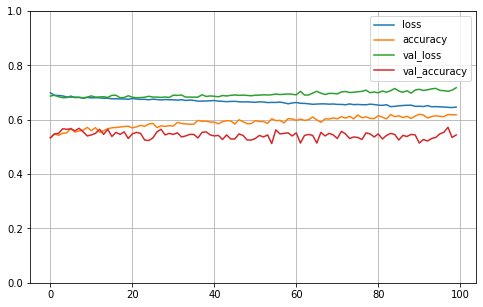

In [58]:
# Training Curve

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [59]:
model.evaluate(X_validation, encoded_Y_val)

17/17 [==============================] - 0s 1ms/step - loss: 0.7177 - accuracy: 0.5441


[0.7177311182022095, 0.5440900325775146]

In [60]:
X_new = X_validation[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.42],
       [0.58],
       [0.5 ]], dtype=float32)

In [61]:
y_pred = model.predict_classes(X_new)
print(y_pred)

np.array(class_names)[y_pred]

[[0]
 [1]
 [1]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([['Decrease'],
       ['Increase'],
       ['Increase']], dtype='<U8')

# Normalised Data

In [62]:
norm_scaler = MinMaxScaler()

price = df.Bitcoin_price.values.reshape(-1, 1)

scaled_price = scaler.fit_transform(price)

# neural_X_scaled = norm_scaler.fit_transform(X)

scaled_close = scaled_close.reshape(-1, 1)

In [63]:
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(neural_X_scaled, Y, test_size=0.20)

In [64]:
X_train = normalize(X_train, axis=1)
X_test = normalize(X_validation, axis=1)

In [65]:
# encode class values as integers
encoder = LabelEncoder()

encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)

encoder.fit(y_validation)
encoded_Y_val = encoder.transform(y_validation)

In [66]:
class_names = ["Increase", "Decrease"]

In [67]:
class_names[encoded_Y[0]]

'Decrease'

In [68]:
model = keras.models.Sequential([
                                 keras.layers.Flatten(input_dim=14),
                                 keras.layers.Dense(300, activation="relu"),
                                 keras.layers.Dropout(rate=0.2),
                                 keras.layers.Dense(100, activation="relu"),
                                 keras.layers.Dropout(rate=0.2),
                                 keras.layers.Dense(80, activation="relu"),
                                 keras.layers.Dropout(rate=0.2),
                                 keras.layers.Dense(1, activation="sigmoid")
                                 ])

In [69]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 14)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 300)               4500      
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 80)                8080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)              

In [70]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [71]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 

history = model.fit(X_train, encoded_Y, epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose = 1,
    shuffle=True,
    callbacks =[earlystopping])

Epoch 1/100
60/60 [==============================] - 1s 5ms/step - loss: 0.6939 - accuracy: 0.5118 - val_loss: 0.6910 - val_accuracy: 0.5280
Epoch 2/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5274 - val_loss: 0.6908 - val_accuracy: 0.5280
Epoch 3/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5167 - val_loss: 0.6910 - val_accuracy: 0.5280
Epoch 4/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5179 - val_loss: 0.6910 - val_accuracy: 0.5280
Epoch 5/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5363 - val_loss: 0.6915 - val_accuracy: 0.5280
Epoch 6/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5203 - val_loss: 0.6900 - val_accuracy: 0.5280
Epoch 7/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6862 - accuracy: 0.5459 - val_loss: 0.6900 - val_accuracy: 0.5280
Epoch 8/100
6

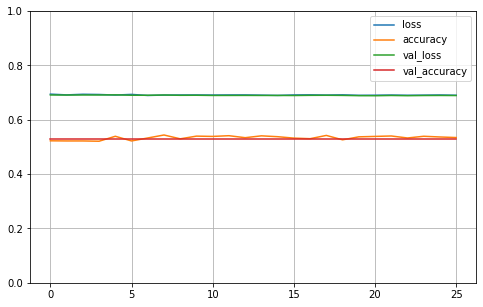

In [72]:
# Training Curve

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [73]:
model.evaluate(X_validation, encoded_Y_val)

17/17 [==============================] - 0s 1ms/step - loss: 0.6849 - accuracy: 0.5591


[0.6848798990249634, 0.5590994358062744]

In [74]:
X_new = X_validation[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.6 ],
       [0.55],
       [0.57]], dtype=float32)

In [75]:
y_pred = model.predict_classes(X_new)
print(y_pred)

np.array(class_names)[y_pred]

[[1]
 [1]
 [1]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([['Decrease'],
       ['Decrease'],
       ['Decrease']], dtype='<U8')

# Final Predictions

In [76]:
y_pred_test = model.predict(X_validation)

df_test['Actual Values'] = Y
df_test["Predictions"] = y_pred_test

df_test.head(20)

NameError: ignored

In [ ]:
df_test.to_csv('predictions.csv', index=False)